In [213]:
import torch
from ResNet import *
import cv2
import matplotlib.pyplot as plt


import seaborn as sns

from PIL import Image
import PIL
from voxel2layer import decode_shape, generate_indices
from voxel2layer_torch import shlx2shl, shl2shlx, generate_indices as torch_generate_indices
from train import iou_shapelayer
from binvox_rw import Voxels, dense_to_sparse
from DatasetCollector import FaustCollector
import numpy as np
import glob
import scipy.io as sio
from crop_images import load_image, crop_image

SHAPENET_CARS = '/path/to/datasets/shapenet/3d_r2n2/ShapeNetRendering/02958343'
OGN_OCTREE_CARS = '/path/to/datasets/ogn_octree/shapenet_cars'

80.37771224975586 38 cars_results_ncomp5_128size_fix_zoom


"\nax2 = fig.add_subplot(122)\nlegends = []\nfor method in glob.glob('./results_ncomp5_128size_fix_zoom/val_iou.npy')[::-1]:\n    val_iou = np.load(method)\n    method_name = method.split('/')[-2]\n    ax2.plot(range(1, len(val_iou)+1), val_iou)\n    legends.append(method_name)\n    print(val_iou.max(), val_iou.argmax()+1, method_name)\nax2.legend(legends)\n"

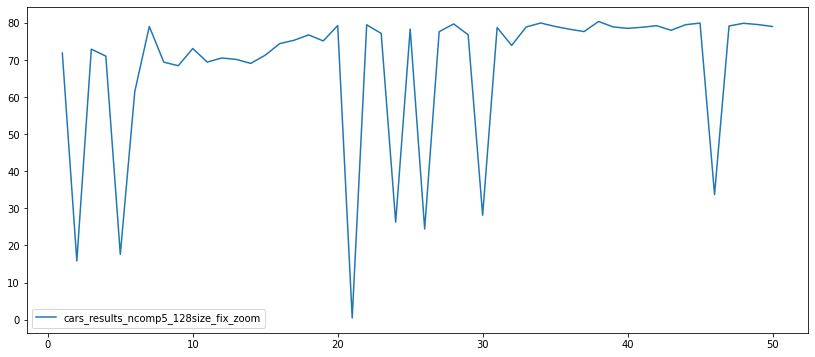

In [214]:
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(111)
legends = []
for method in ['./cars_results_ncomp5_128size_fix_zoom/val_iou.npy']:
    val_iou = np.load(method)
    method_name = method.split('/')[-2]
    ax1.plot(range(1, len(val_iou)+1), val_iou)
    legends.append(method_name)
    print(val_iou.max(), val_iou.argmax()+1, method_name)
ax1.legend(legends)

In [83]:
savegame = torch.load('./cars_results_ncomp5_128size_fix_zoom/matryoshka_ShapeNetCars_38.pth.tar')

In [84]:
N_COMP = 5

net = ResNet(
    num_input_channels=3, 
    num_initial_channels=savegame['ninf'],
    num_inner_channels=savegame['ngf'],
    num_penultimate_channels=savegame['noutf'], 
    num_output_channels=6*N_COMP,
    input_resolution=128, 
    output_resolution=savegame['side'],
    num_downsampling=savegame['down'], 
    num_blocks=savegame['block']
)
net.load_state_dict(savegame['state_dict'])

<All keys matched successfully>

In [85]:
_ = net.eval()

In [209]:
RES = 128
RES_NAME = FaustCollector.res2name[str(RES)]
is_zoom = 1
is_white = 1
all_car_images_path = sorted(glob.glob(f'{SHAPENET_CARS}/*'), key=lambda x: x.split('/')[-1])

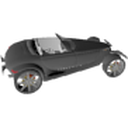

(None, (128, 128), '02.png')

In [210]:
if is_white and is_zoom:
    map_to = 255
    back_v = 255
elif is_white and not is_zoom:
    map_to = 255
    back_v = 128
elif not is_white and is_zoom:
    map_to = 128
    back_v = 128
elif not is_white and not is_zoom:
    map_to = 128
    back_v = 255
    
index_random = np.random.randint(0, len(all_car_images_path))
random_obj = all_car_images_path[index_random]
random_obj = f'{random_obj}/rendering/02.png'
img = Image.open(random_obj)
img = load_image(img, alpha_map_to=map_to)
img = crop_image(img, 128, background_value=back_v)
img.show(), img.size, random_obj.split('/')[-1]

In [211]:
input_tensor = np.array(img)
input_tensor = torch.from_numpy(input_tensor)
input_tensor = input_tensor.unsqueeze(0)
input_tensor = input_tensor.float() / 255.0
input_tensor = input_tensor.permute(0, -1, 1, 2)

predicted_original_tensor = net(input_tensor).detach()
predicted_tensor = shlx2shl(predicted_original_tensor.clone().detach())
predicted_tensor = predicted_tensor.detach()
predicted_tensor = predicted_tensor.permute(0, 2, 3, 1)

obj_name = str(index_random).zfill(4)
d = sio.loadmat(f'{OGN_OCTREE_CARS}/{RES_NAME}/{obj_name}.shl.mat')
sh = torch.from_numpy(np.array(d['shapelayer'], dtype=np.int32)[:,:,:6*N_COMP]).permute(2,0,1).contiguous().float() 

id1_t, id2_t, id3_t = torch_generate_indices(RES)
pred = shlx2shl(predicted_original_tensor.clone().detach())
target = sh.clone().detach().unsqueeze(0)
iou, bs  = iou_shapelayer(pred, target, id1_t, id2_t, id3_t)
iou

tensor(0.4054)

<AxesSubplot:>

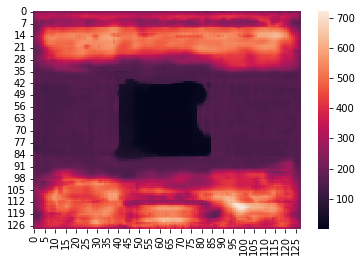

In [212]:
i_comp = 0
#sns.heatmap(predicted_original_tensor[0,0,:])
sns.heatmap(predicted_tensor[0,:,:, 0 + 6 * i_comp])

(<AxesSubplot:>, tensor(130.))

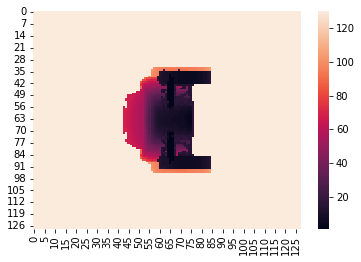

In [208]:
sns.heatmap(sh[0]), sh[:,].max()

In [52]:
id1, id2, id3 = generate_indices(RES)
decoded = decode_shape(sh.permute(1, 2, 0), id1, id2, id3)
#decoded = (decoded > 1e-3).astype(int)
decoded.shape, decoded.sum(), decoded.max(), decoded.min()

((128, 128, 128), 89940, 1, 0)

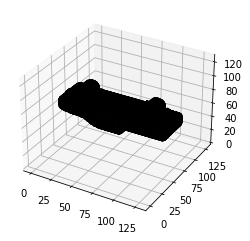

In [53]:
fig = plt.figure()
ax = plt.subplot(projection='3d')

ax.voxels(decoded, edgecolors='k')
plt.show()

In [54]:
id1, id2, id3 = generate_indices(RES)
decoded = predicted_tensor.detach()
decoded = decode_shape(decoded[0], id1, id2, id3)
#decoded = (decoded > 1e-3).astype(int)
decoded.shape, decoded.sum(), decoded.max(), decoded.min()

((128, 128, 128), 92250, 1, 0)

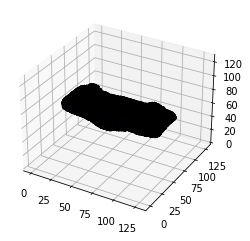

In [55]:
fig = plt.figure()
ax = plt.subplot(projection='3d')

ax.voxels(decoded, edgecolors='k')
plt.show()

In [58]:
voxel_model = Voxels(decoded, [RES, RES, RES], np.array([0.0,0.0,0.0]),1.0,'xzy')

In [59]:
with open('result.binvox', 'a') as f:
    voxel_model.write(f)

In [ ]:
pred    = net(input_tensor)

In [ ]:
from voxel2layer_torch import shlx2shl

sh = shlx2shl(pred)

In [ ]:
from train import iou_voxel, iou_shapelayer

iou, bs = iou_shapelayer(sh, targets, id1, id2, id3)

In [ ]:
# https://raahii.github.io/simple_voxel_viewer/index.html
# https://drububu.com/miscellaneous/voxelizer/?out=obj